<a href="https://colab.research.google.com/github/Ayrsz/SignalAndSistemyProject/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
#ML
import sklearn as sk
import xgboost as xgb
#Scientific computation
import numpy as np
import jax
import jax.numpy as jnp

#Plot and view
from matplotlib import pyplot as plt
import seaborn as sea

#Data manipulation
import os
import gc
import pandas as pd
import cv2 as cv

#Audio manipulation
import librosa
import soundfile as sf


In [2]:
from zipfile import ZipFile
try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount= True)
except Exception as e:
    print(e)
    print("Código rodando localmente")

path_root = "/home/mas11/Documents/Datasets"


No module named 'google.colab'
Código rodando localmente


# Dataset config

In [6]:
data = pd.read_csv(path_root + "/Data/feats.csv")
data.head()

,name,dir_image,rms_mean,rms_std,zero_cross_mean,zero_cross_std,amplitude_envelope_mean,amplitude_envelope_std,spectral_centroid_mean,spectral_centroid_std,...,mfcc#09_mean,mfcc#09_std,mfcc#10_mean,mfcc#10_std,mfcc#11_mean,mfcc#11_std,mfcc#12_mean,mfcc#12_std,tempo,label
0,classical_noise_emphased_orig00080.00413.wav,/home/mas11/Documents/Datasets/Data/images/cla...,0.0249,0.0018,0.6003,0.0573,0.0810,0.0104,6376.9871,228.1002,...,0.2442,3.5097,0.9208,3.4644,1.1831,3.4259,1.6934,3.3087,[107],classical_noise_emphased_orig00080
1,classical_echo_percusive_orig00090.00130.wav,/home/mas11/Documents/Datasets/Data/images/cla...,0.0062,0.0016,0.2169,0.0586,0.0176,0.0080,2773.6996,398.8818,...,31.7425,9.4086,-1.1821,8.5750,21.3737,10.0200,-4.3270,10.3749,[69],classical_echo_percusive_orig00090
2,classical.00014.wav,/home/mas11/Documents/Datasets/Data/images/cla...,0.0334,0.0216,0.0684,0.0240,0.0839,0.0695,1279.5155,313.6353,...,0.8444,8.8088,-8.1923,8.0725,-0.8276,9.9700,0.9924,12.2557,[143],classical
3,classical_gain_emphased_orig00079.00344.wav,/home/mas11/Documents/Datasets/Data/images/cla...,0.0559,0.0301,0.0545,0.0204,0.1298,0.0869,972.0606,260.2904,...,-8.5422,10.9619,-8.1383,12.7427,-8.8796,15.0575,-6.8608,11.2598,[143],classical_gain_emphased_orig00079
4,classical_percusive_trim_orig00090.00134.wav,/home/mas11/Documents/Datasets/Data/images/cla...,0.0033,0.0009,0.2066,0.0715,0.0091,0.0050,2759.2789,481.3810,...,30.0558,9.6905,0.9157,8.8482,21.9807,9.8172,-1.9290,10.7325,[112],classical_percusive_trim_orig00090


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5994 entries, 0 to 5993
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     5994 non-null   object 
 1   dir_image                5994 non-null   object 
 2   rms_mean                 5994 non-null   float64
 3   rms_std                  5994 non-null   float64
 4   zero_cross_mean          5994 non-null   float64
 5   zero_cross_std           5994 non-null   float64
 6   amplitude_envelope_mean  5994 non-null   float64
 7   amplitude_envelope_std   5994 non-null   float64
 8   spectral_centroid_mean   5994 non-null   float64
 9   spectral_centroid_std    5994 non-null   float64
 10  hog_mean                 5994 non-null   float64
 11  hog_std                  5994 non-null   float64
 12  mfcc#00_mean             5994 non-null   float64
 13  mfcc#00_std              5994 non-null   float64
 14  mfcc#01_mean            

# Treating data

In [8]:
labeling = lambda name : name.split("_")[0]
data["label"] = data["label"].apply(labeling)

In [9]:
unvetorize = lambda num: float(num.strip("[]"))


data["tempo"] = data["tempo"].apply(unvetorize)

#Alguns estão com tempo 0, vou resolver
data = data[data["tempo"] != 0]

In [10]:
change_dir = lambda path: path.replace('Datasets', 'Datasets/Data')
data["dir_image"] = data["dir_image"].apply(change_dir)

In [11]:
# Dicionario, label -> Idx (labelEnconder)
#Transformar classes em numeros
label_mapping = {label: int(idx) for idx, label in enumerate(data["label"].unique())}
label_unmapping = {int(idx) : label for label, idx in label_mapping.items()}
data["label"] = data["label"].map(label_mapping)

In [12]:
data = data.dropna()

# Analise exploratória

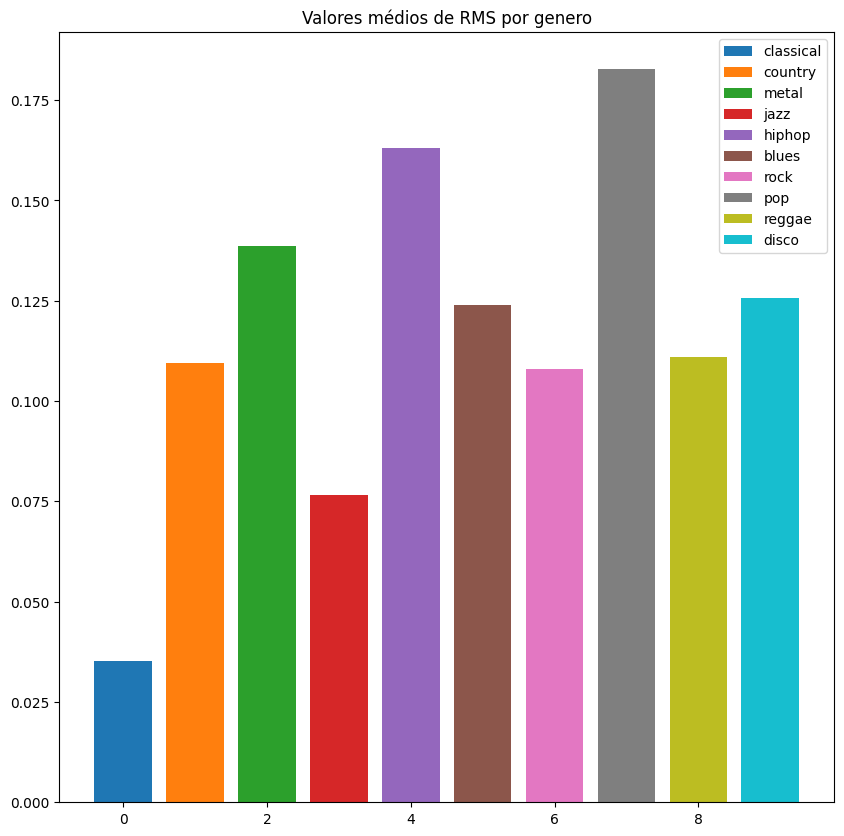

In [14]:
def plot_rms_per_genre(df):
    labels = np.unique(df["label"])
    means = {}



    for label in labels:

        df.head()
        
        name_genre = label_unmapping[label]

        rms_genre = df[df["label"] == label]["rms_mean"]
        mean = rms_genre.mean()
        means[name_genre] = mean

    i = 0
    plt.figure(figsize= (10, 10))
    plt.title("Valores médios de RMS por genero")
    for (label, value) in means.items():
        plt.bar(i, value)
        i = i + 1
    
    plt.legend(means.keys())
   # plt.

plot_rms_per_genre(data)
#data.head()


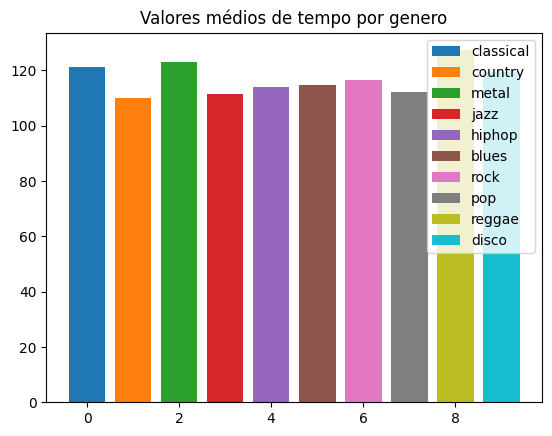

In [72]:
def plot_tempo(df):
    labels = np.unique(df["label"])
    means = {}

    for label in labels:

        df.head()
        
        name_genre = label_unmapping[label]

        tempo_genere = df[df["label"] == label]["tempo"]
        mean = tempo_genere.mean()
        means[name_genre] = mean

    i = 0
   # plt.figure(figsize= (10, 10))
    plt.title("Valores médios de tempo por genero")
    for (label, value) in means.items():
        plt.bar(i, value)
        i = i + 1
    
    plt.legend(means.keys())
   # plt.

plot_tempo(data)
#data.head()
    

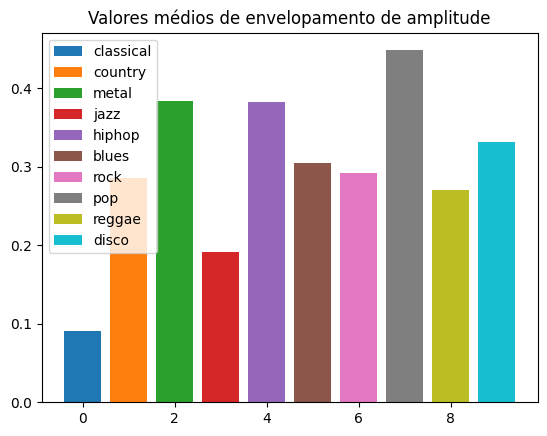

In [78]:
def plot_envelope_amplitude(df):
    labels = np.unique(df["label"])
    means = {}

    for label in labels:

        df.head()
        
        name_genre = label_unmapping[label]

        tempo_genere = df[df["label"] == label]["amplitude_envelope_mean"]
        mean = tempo_genere.mean()
        means[name_genre] = mean

    i = 0
   # plt.figure(figsize= (10, 10))
    plt.title("Valores médios de envelopamento de amplitude")
    for (label, value) in means.items():
        plt.bar(i, value)
        i = i + 1
    
    plt.legend(means.keys())

plot_envelope_amplitude(data)

# Modelo

In [16]:
non_feat = ["label", "dir_image", "name"]

columns = data.columns
data_feat = data.drop(columns = non_feat)
data_non_feat = data.drop(columns = data_feat.columns)

names = data["name"]
dir_imgs = data["dir_image"]
labels = data["label"]

labels.head()


0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [18]:
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(data_feat, labels, test_size= 0.2)

In [65]:
model = xgb.XGBClassifier()
model.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [67]:
pred = model.predict(X_test)
print(f"Numero de erros  {np.sum(pred != Y_test)}")
print(f"Numero acertos, {np.sum(pred == Y_test)}")
print(f"Precisão : {np.sum(pred == Y_test)*100/len(pred)}%")


Numero de erros  208
Numero acertos, 991
Precisão : 82.65221017514595%


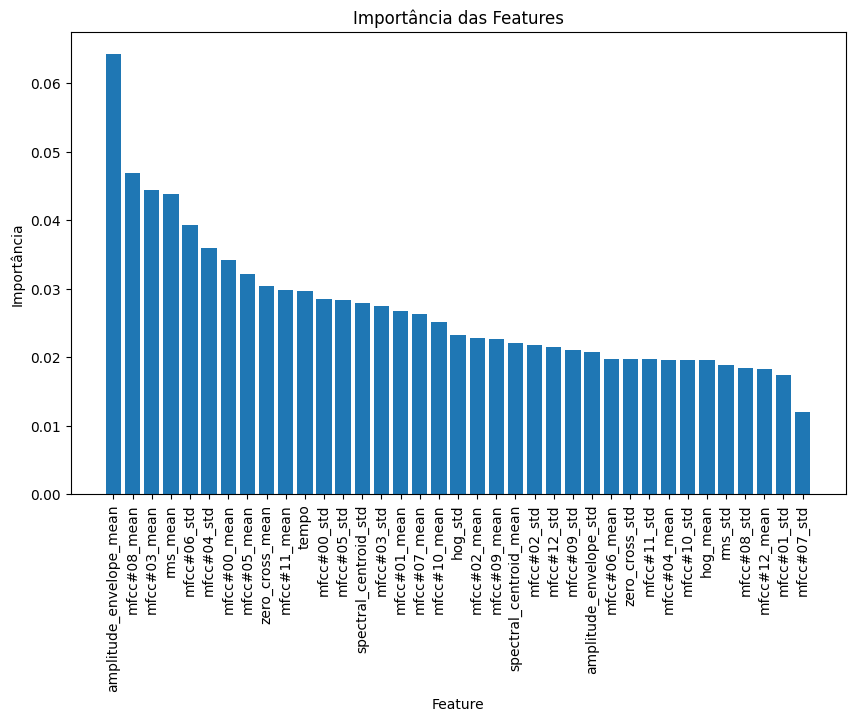

In [68]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Importância das Features")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(data_feat.columns)[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importância")
plt.show()

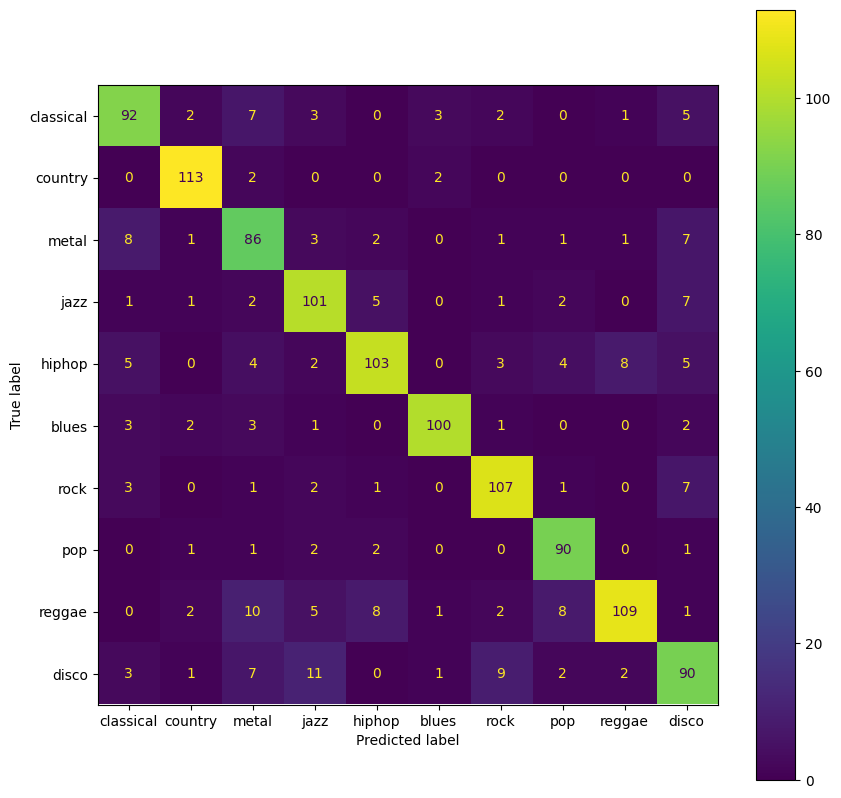

In [69]:
Y_right = [label_unmapping[i] for i in Y_test]
pred_right = [label_unmapping[i] for i in pred]
conf_matrix = sk.metrics.confusion_matrix(Y_right, pred_right)

def show_conf(conf_matrix):
    labels = label_unmapping.values()
    disp = sk.metrics.ConfusionMatrixDisplay(confusion_matrix= conf_matrix, display_labels= labels)
    
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax)


show_conf(conf_matrix)

